<a href="https://colab.research.google.com/github/TJ-dotcom/pyproj/blob/main/GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'pyproj'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3

# Connect to the SQLite database (it will be created if it doesn't exist)
conn = sqlite3.connect('housing_data.db')
cursor = conn.cursor()

# Create the tables
cursor.execute('''
    CREATE TABLE IF NOT EXISTS city (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT UNIQUE
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS statezip (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        code TEXT UNIQUE
    )
''')



cursor.execute('''
    CREATE TABLE IF NOT EXISTS housing (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        price REAL,
        bedrooms REAL,
        bathrooms REAL,
        sqft_living REAL,
        sqft_lot REAL,
        floors REAL,
        waterfront INTEGER,
        view INTEGER,
        condition INTEGER,
        sqft_above REAL,
        sqft_basement REAL,
        yr_built INTEGER,
        yr_renovated INTEGER,
        street TEXT,
        city_id INTEGER,
        statezip_id INTEGER,
        country_id INTEGER,
        FOREIGN KEY (city_id) REFERENCES city(id),
        FOREIGN KEY (statezip_id) REFERENCES statezip(id),
        FOREIGN KEY (country_id) REFERENCES country(id)
    )
''')

# Function to get or create a foreign key reference
def get_or_create_fk(cursor, table, column, value):
    cursor.execute(f'SELECT id FROM {table} WHERE {column} = ?', (value,))
    result = cursor.fetchone()
    if result:
        return result[0]
    else:
        cursor.execute(f'INSERT INTO {table} ({column}) VALUES (?)', (value,))
        return cursor.lastrowid

# Read the CSV file and insert the data into the database
with open('/content/sample_data/housePricing.csv', 'r') as file:
    next(file)  # Skip the header row
    for line in file:
        row = line.strip().split(',')
        row = [None if value == '' else value for value in row]

        # Get or create foreign key references
        city_id = get_or_create_fk(cursor, 'city', 'name', row[15])
        statezip_id = get_or_create_fk(cursor, 'statezip', 'code', row[16])
        country_id = get_or_create_fk(cursor, 'country', 'name', row[17])

        # Insert the row into the housing table
        cursor.execute('''
            INSERT INTO housing (
                date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors,
                waterfront, view, condition, sqft_above, sqft_basement, yr_built,
                yr_renovated, street, city_id, statezip_id, country_id
            )
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', row[:15] + [city_id, statezip_id, country_id])

# Commit the changes and close the connection
conn.commit()
conn.close()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=5f9694c7c5aff557346e6f125283dbb9a6df0b7087ba1df81344567edbea395c
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Null Values:
date             1848
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
street              0
city                0
statezip            0
country             0
dtype: int64

Missing Values:
date             1848
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
street              0
city                0
statezip            0
country             0
dtype: int64


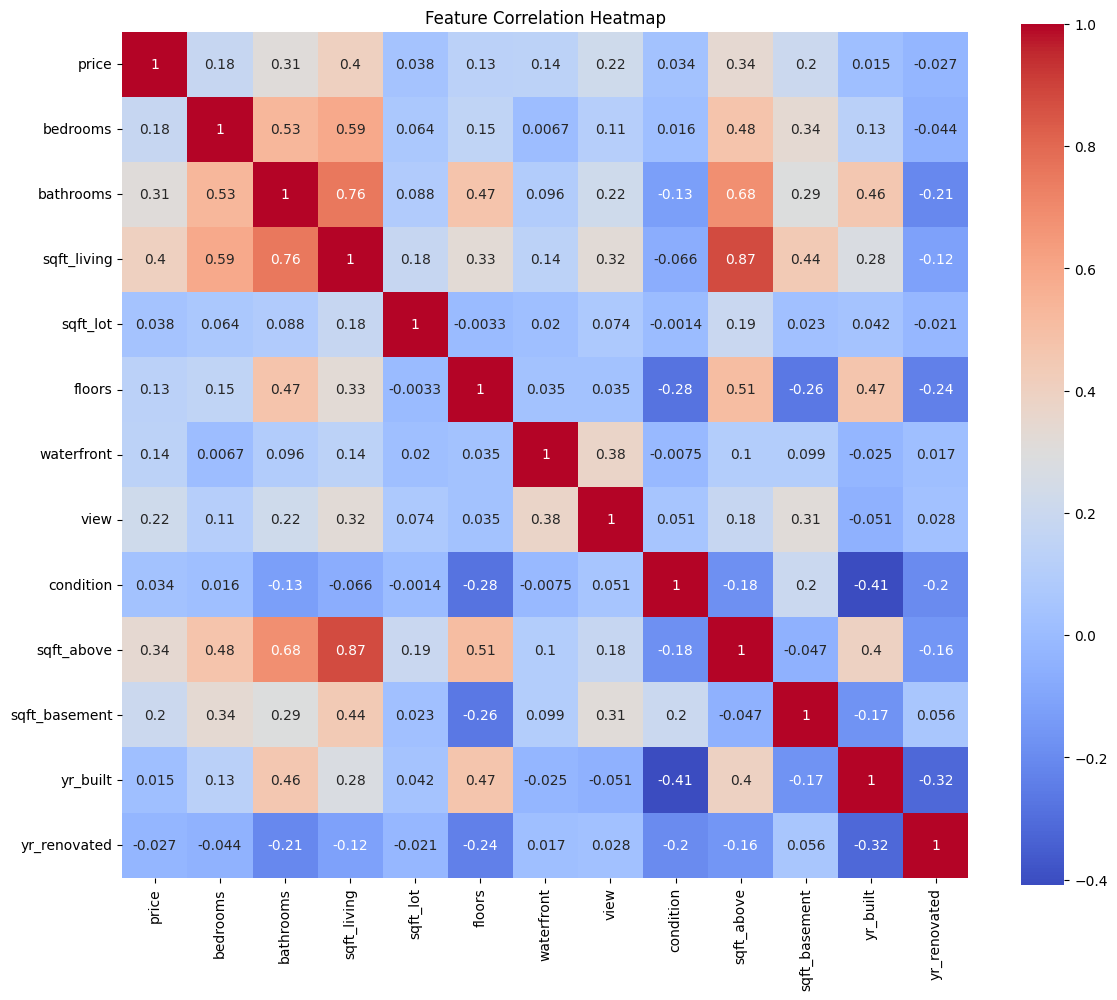

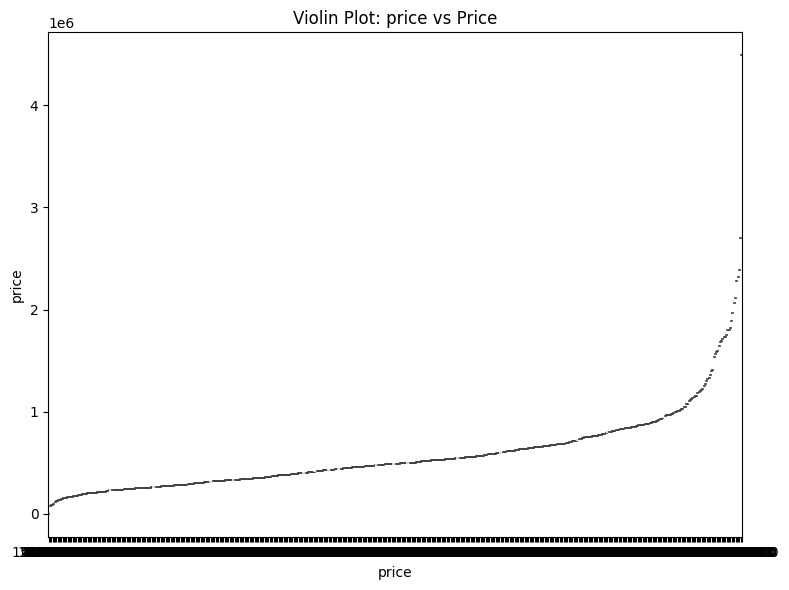

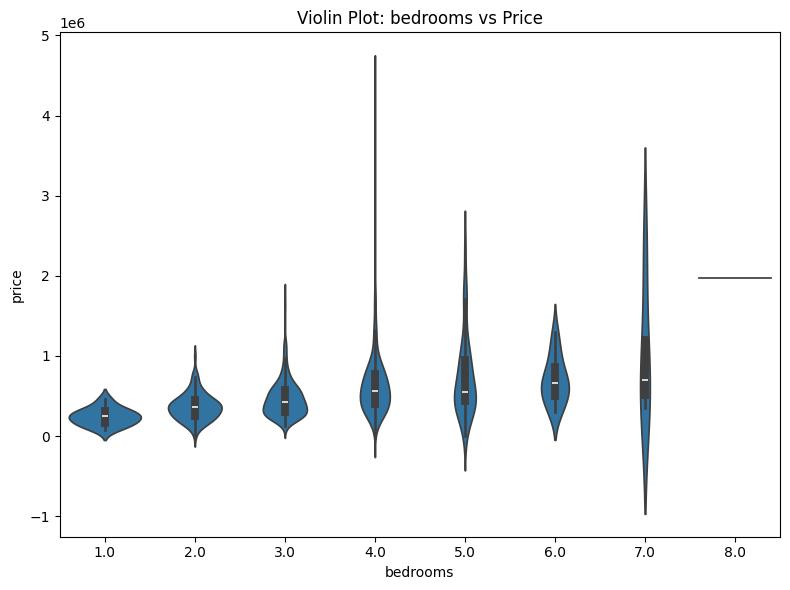

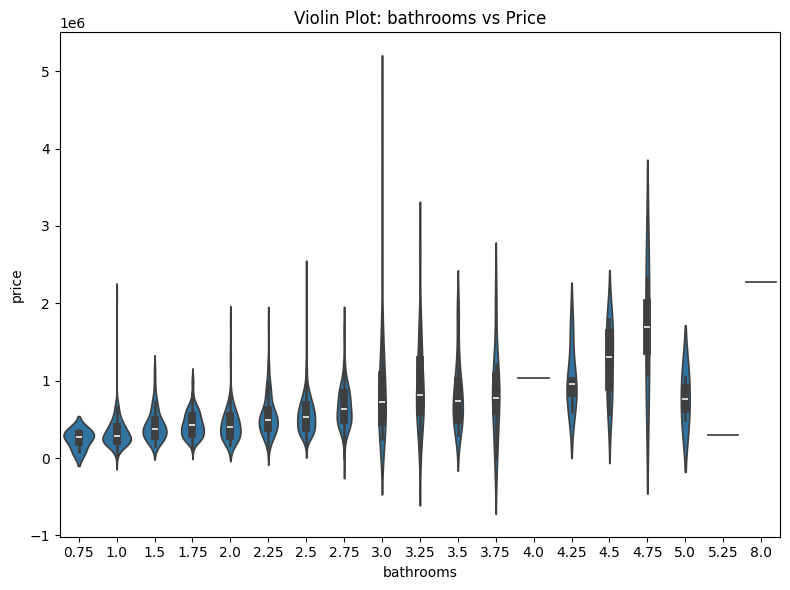

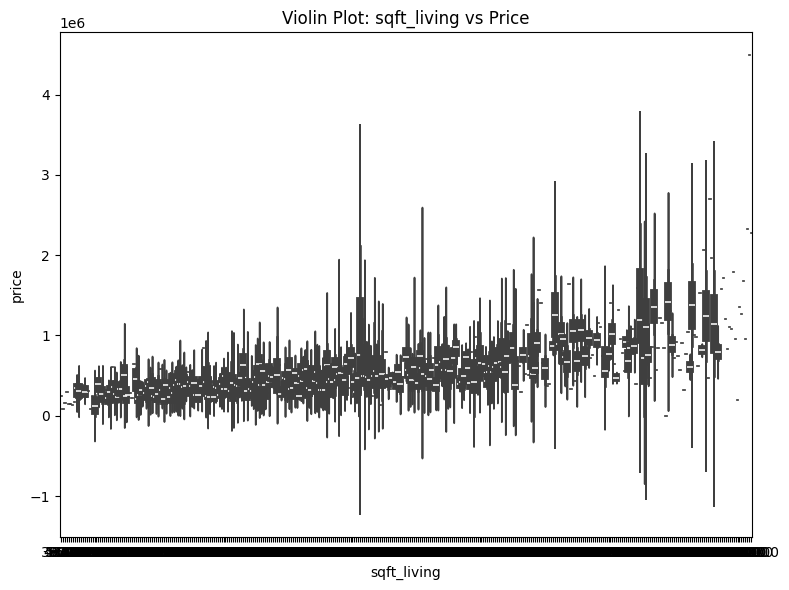

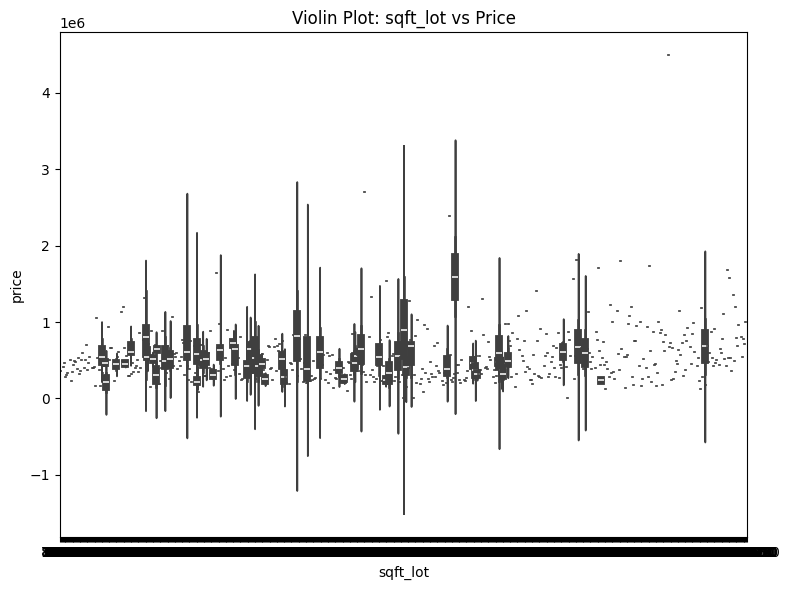

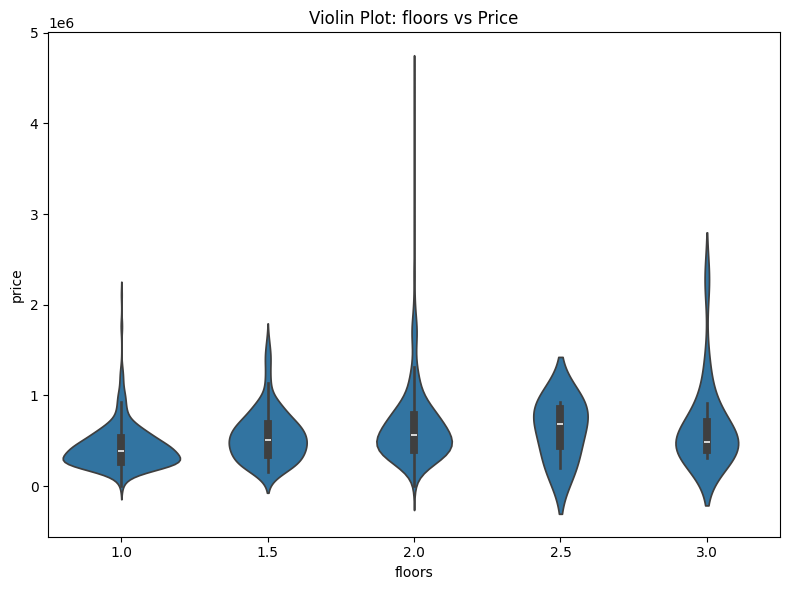

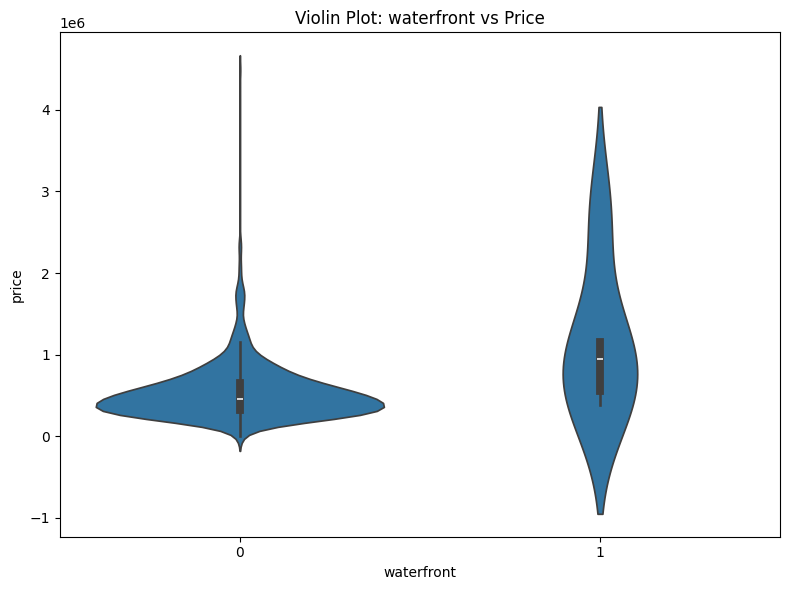

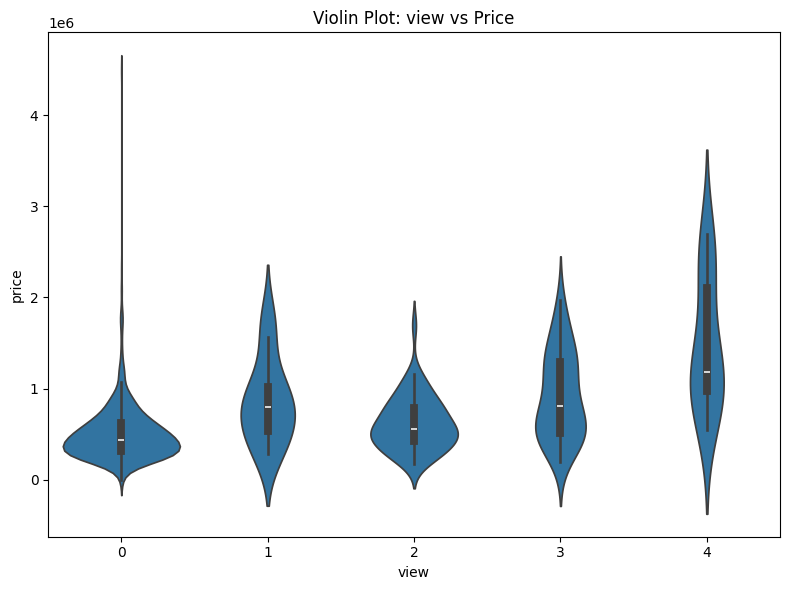

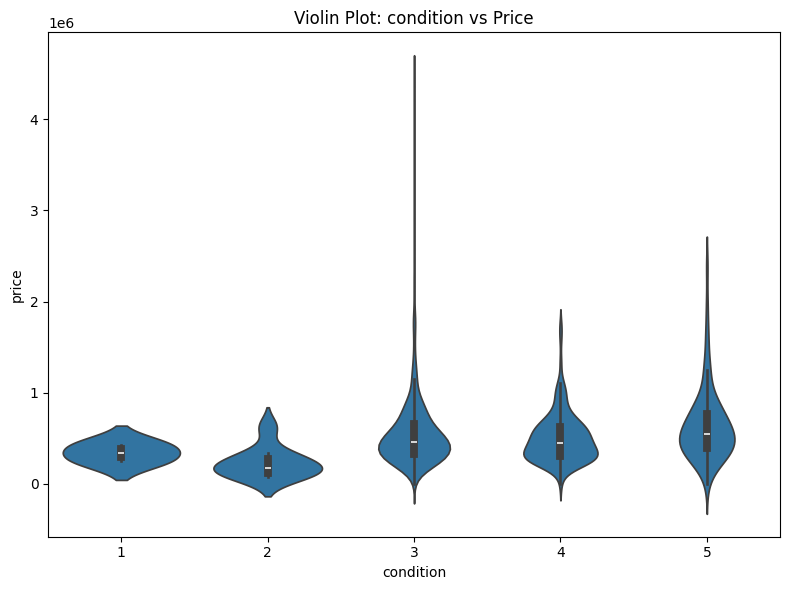

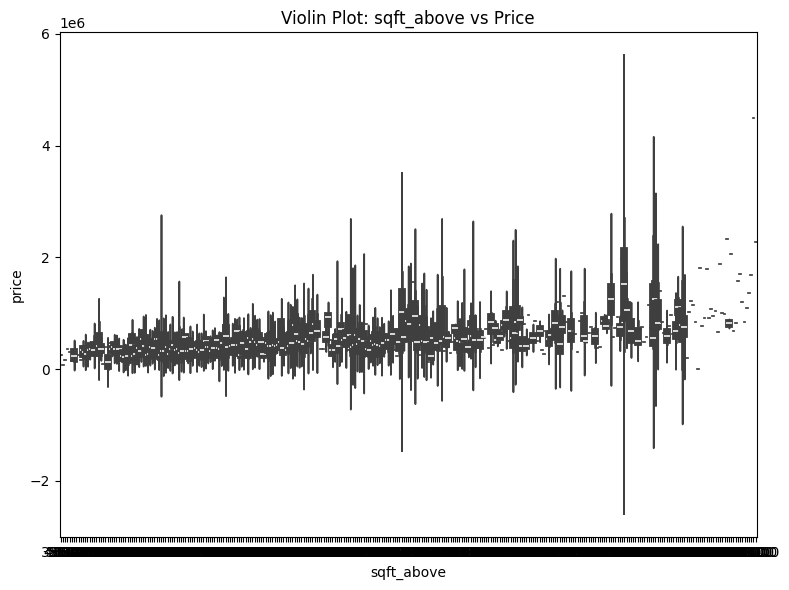

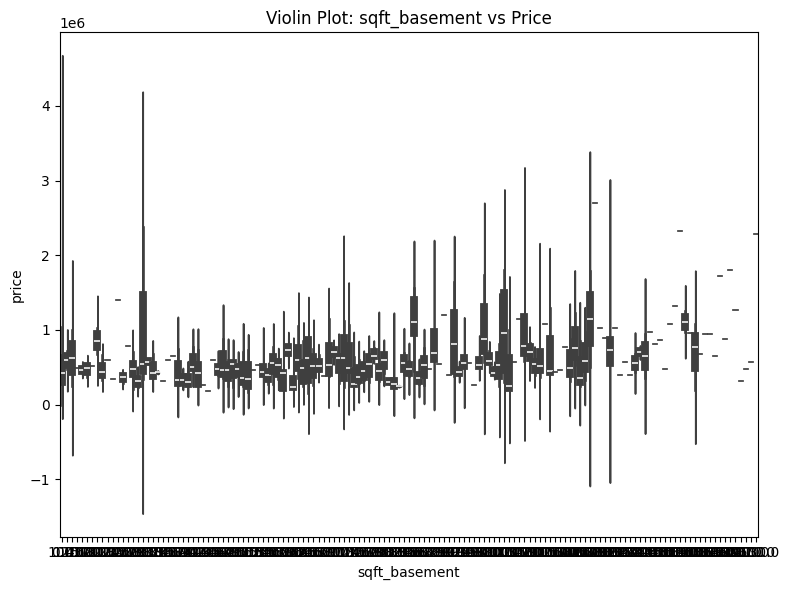

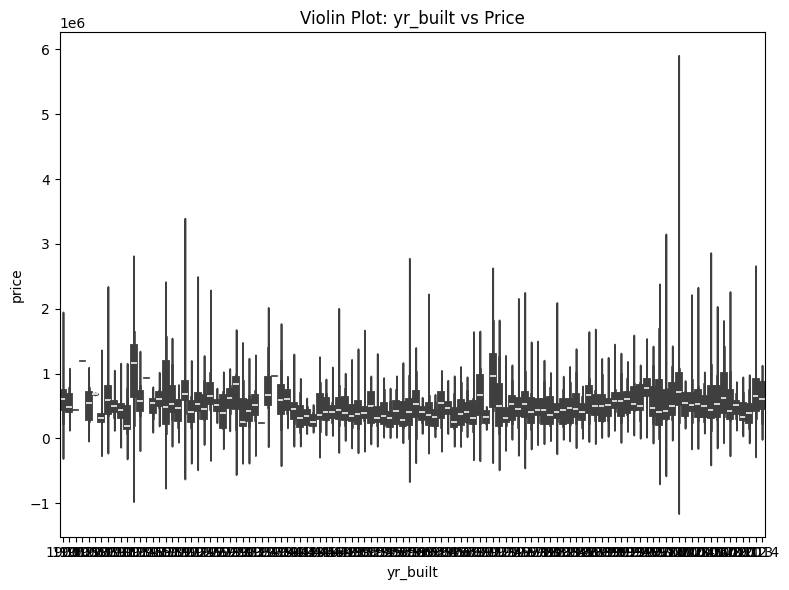

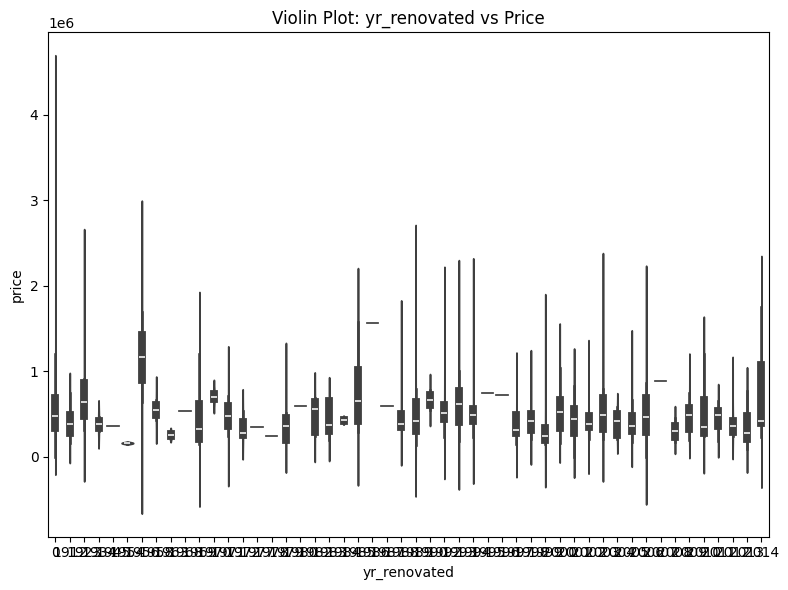

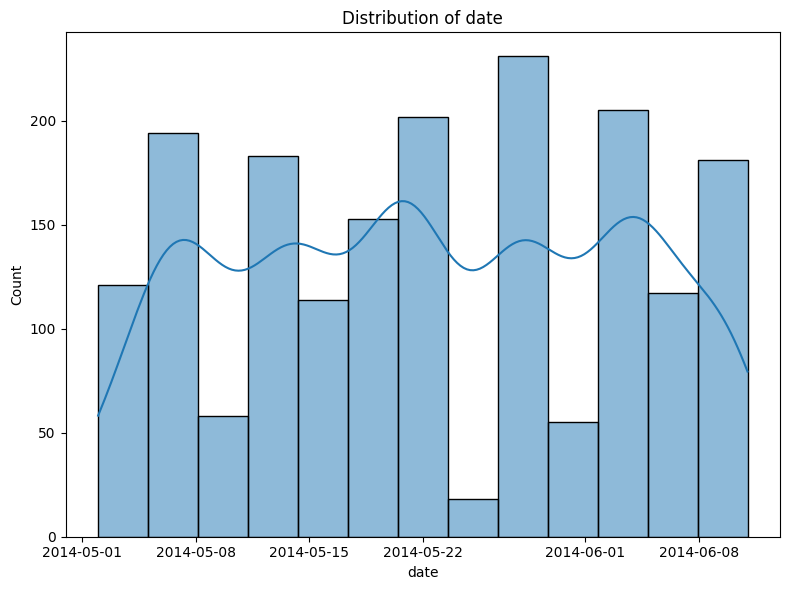

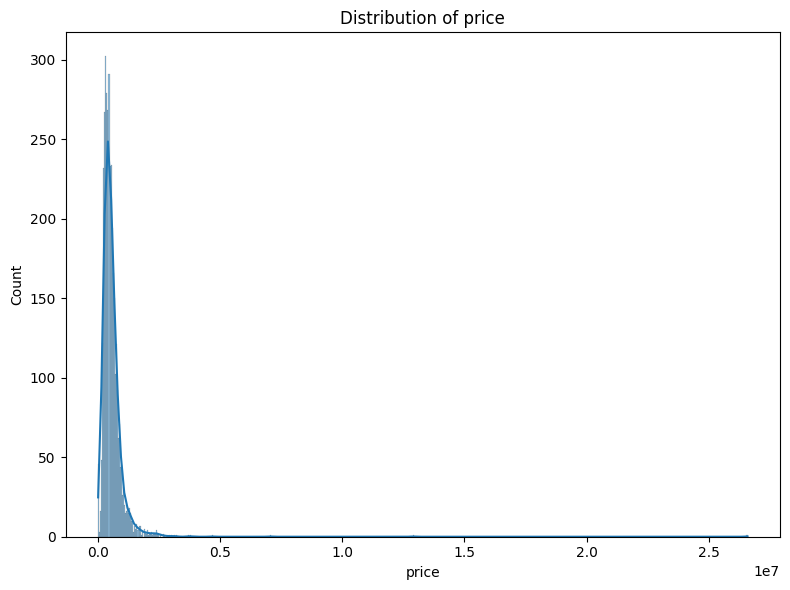

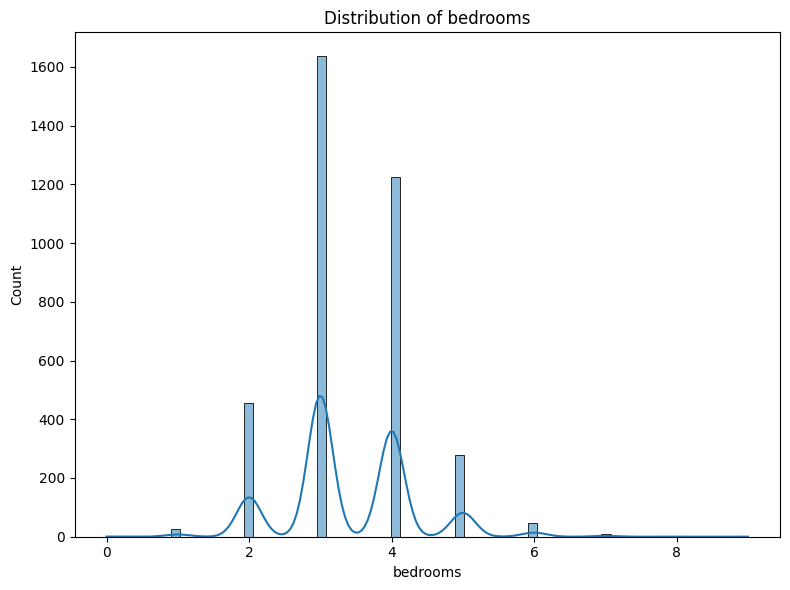

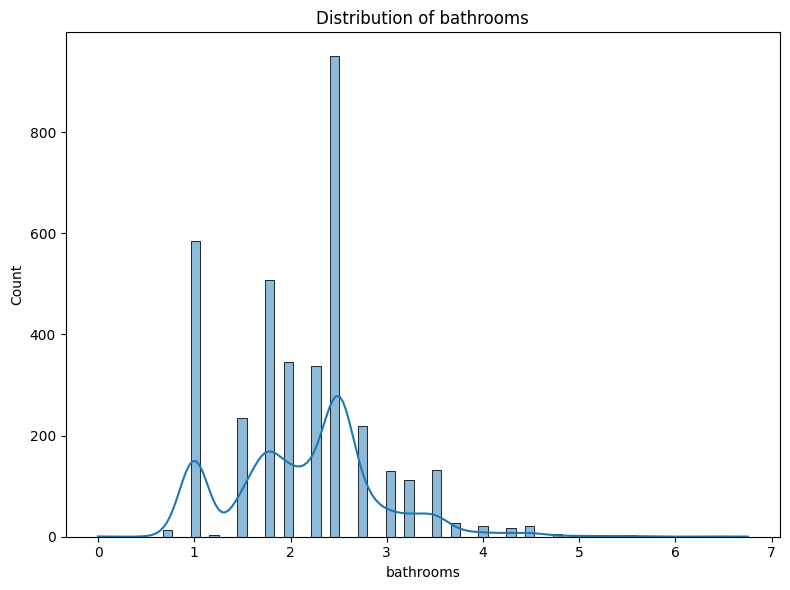

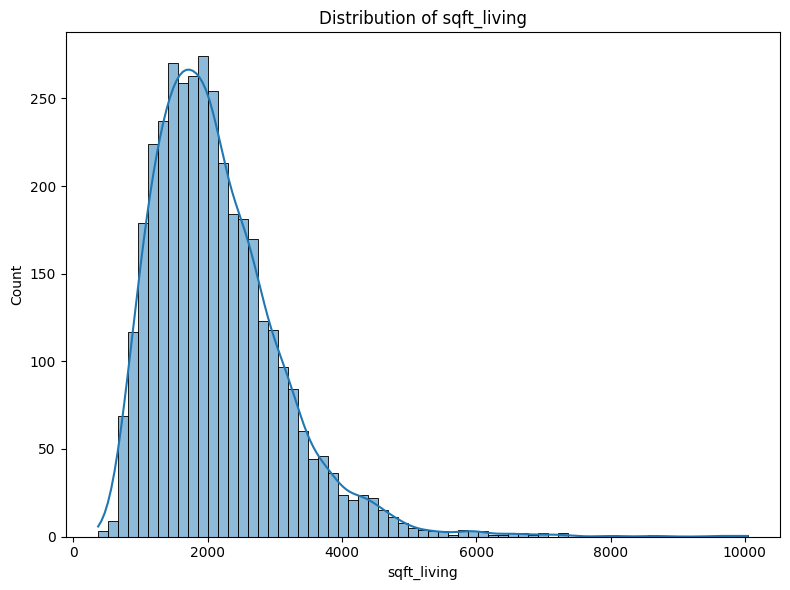

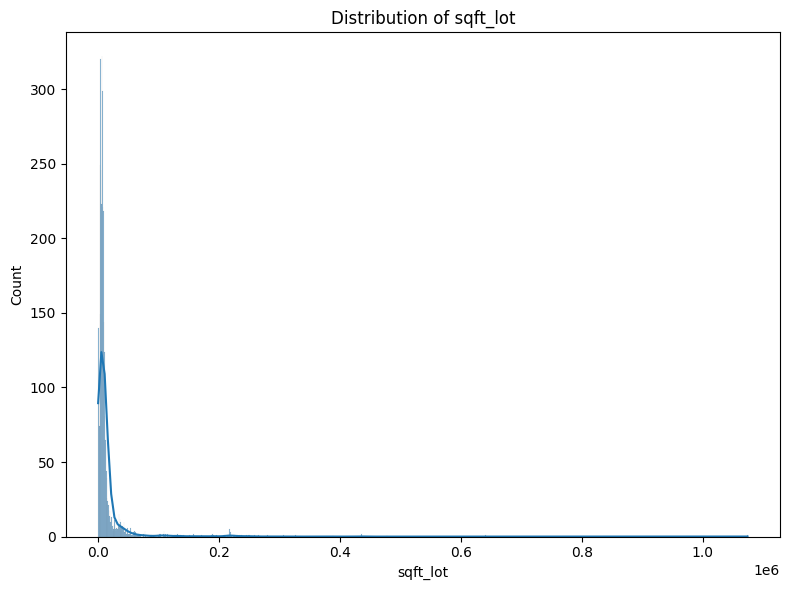

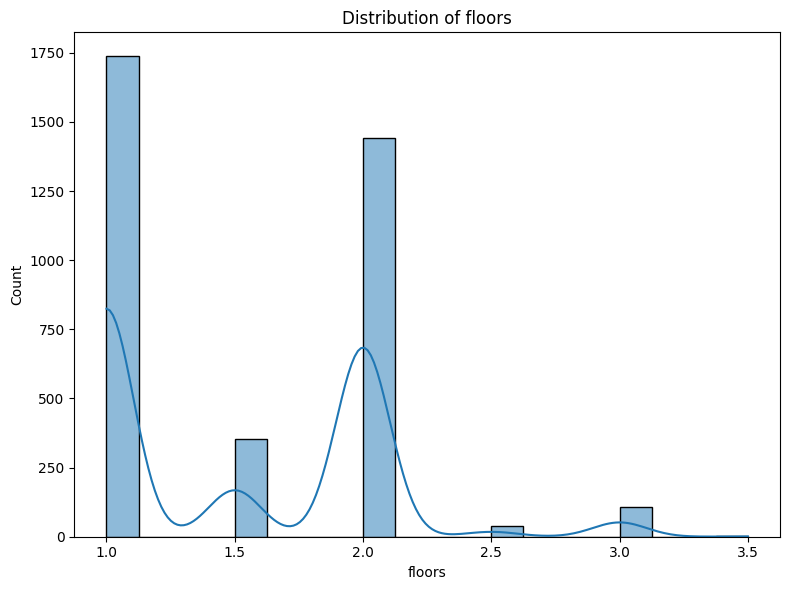

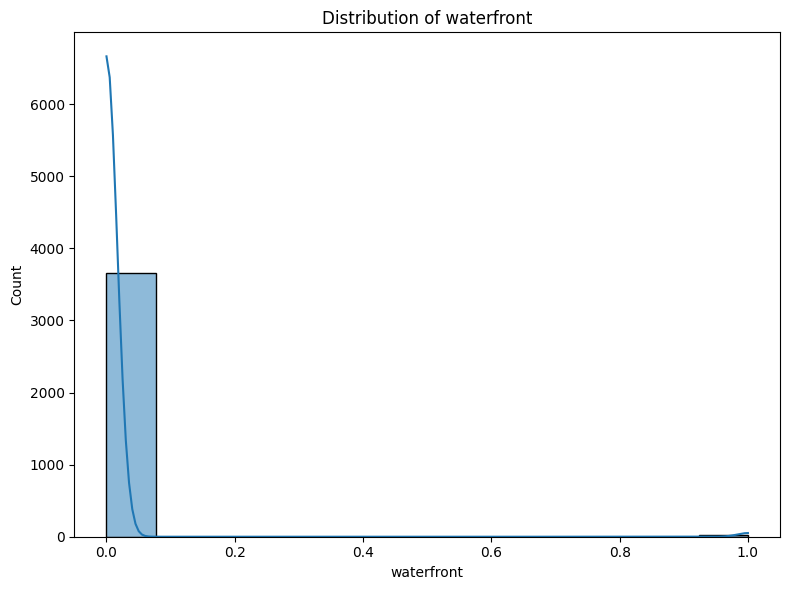

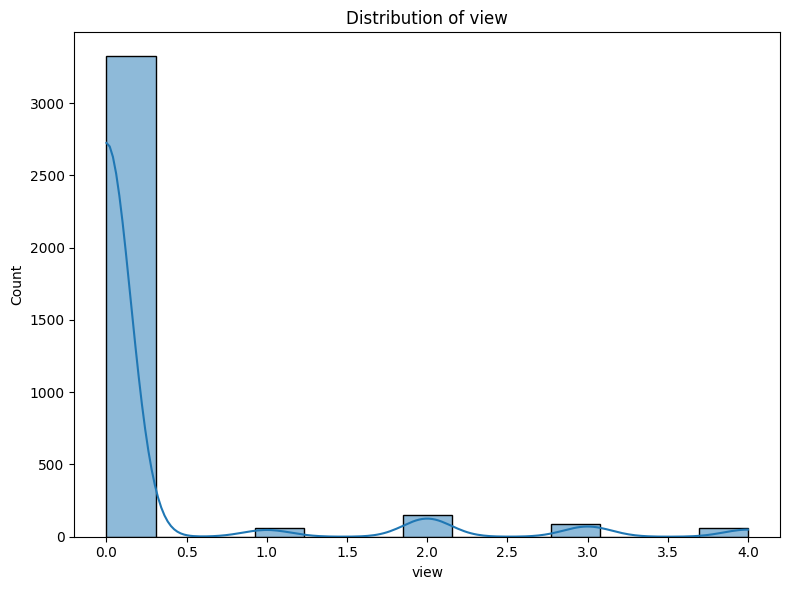

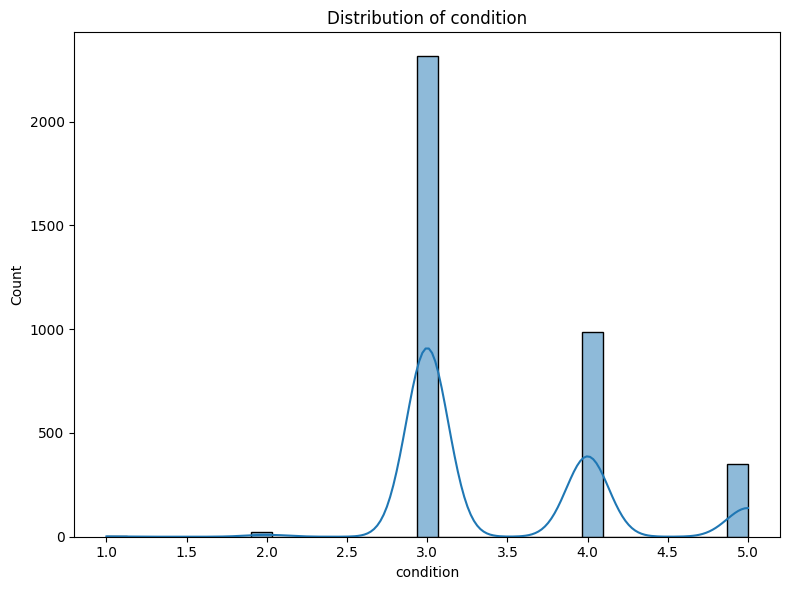

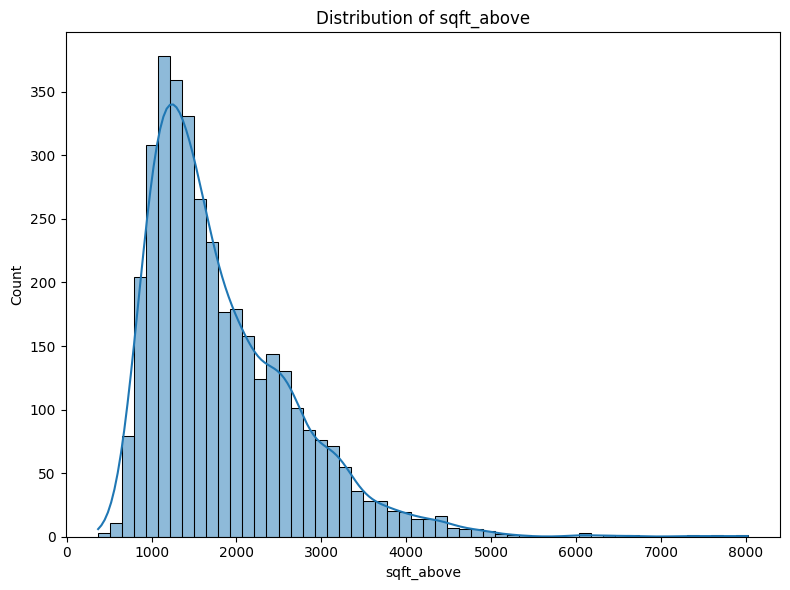

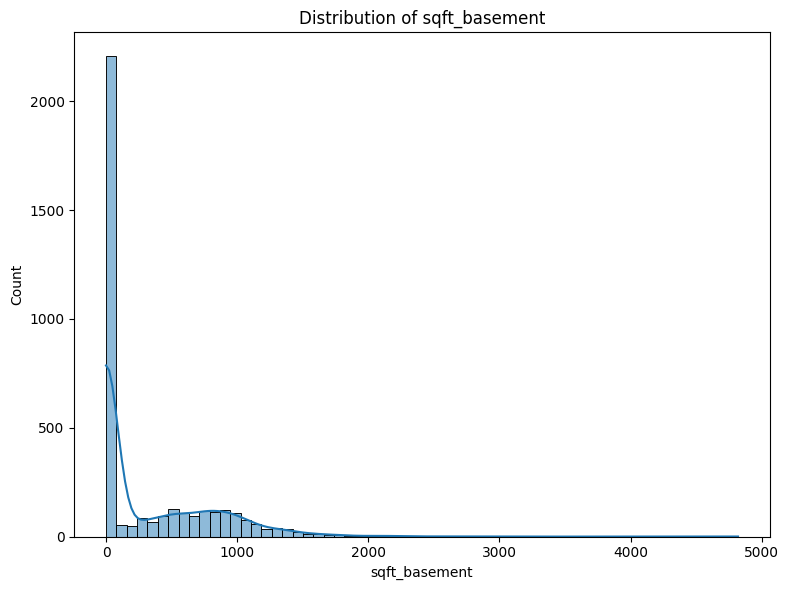

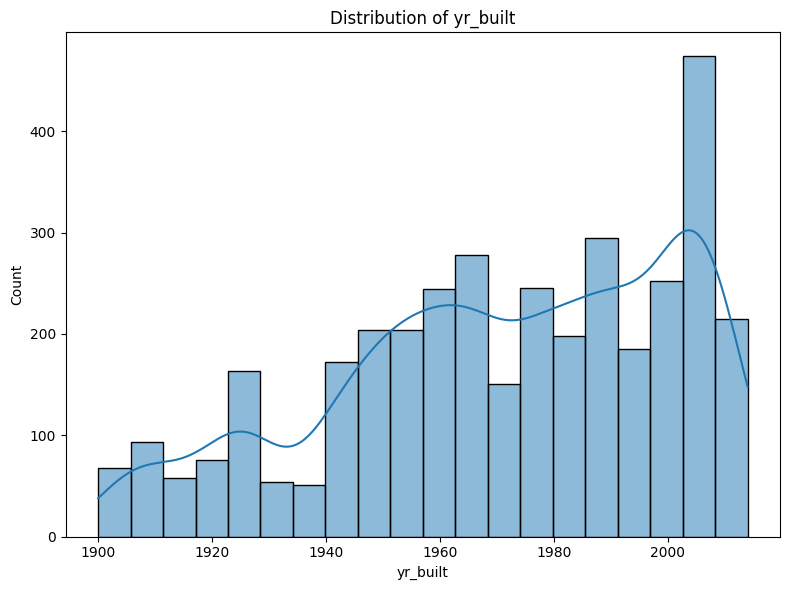

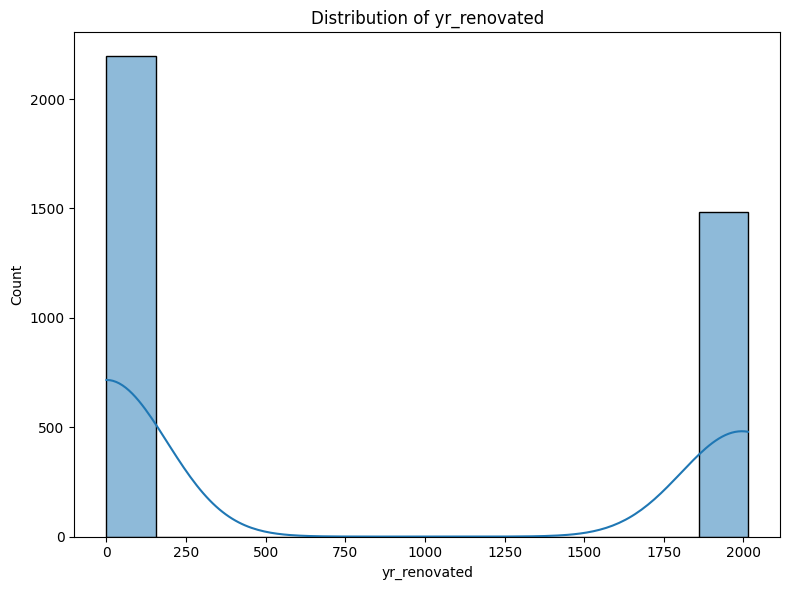

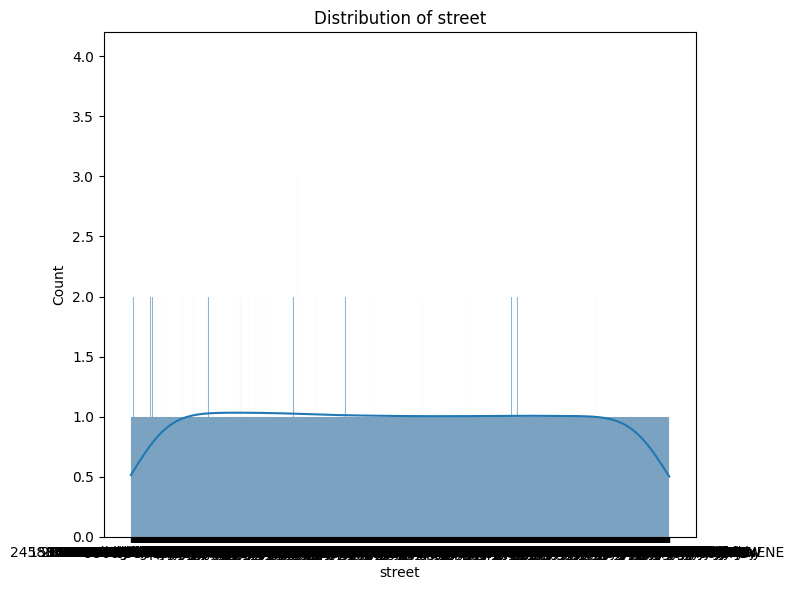

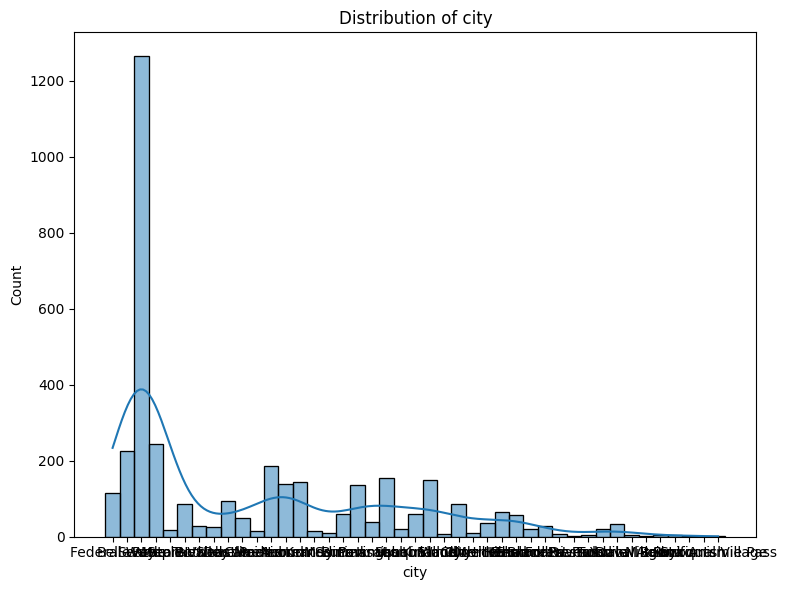

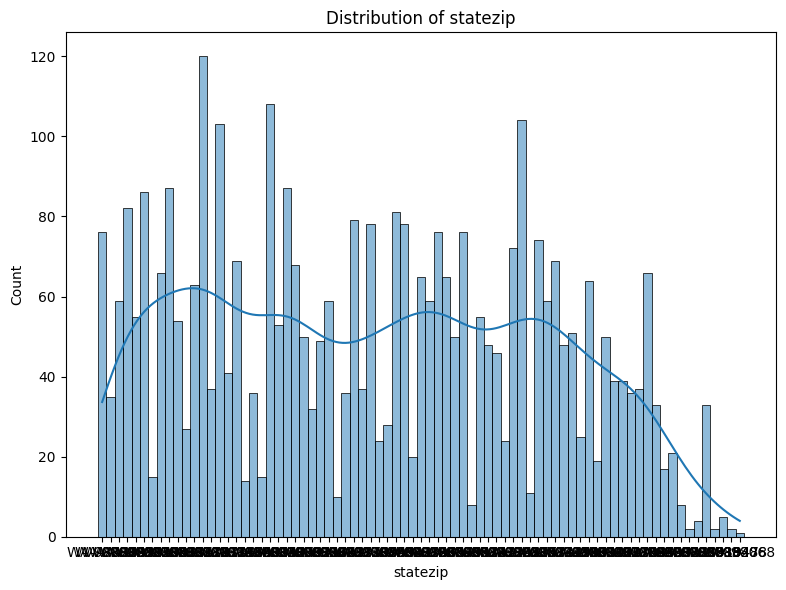

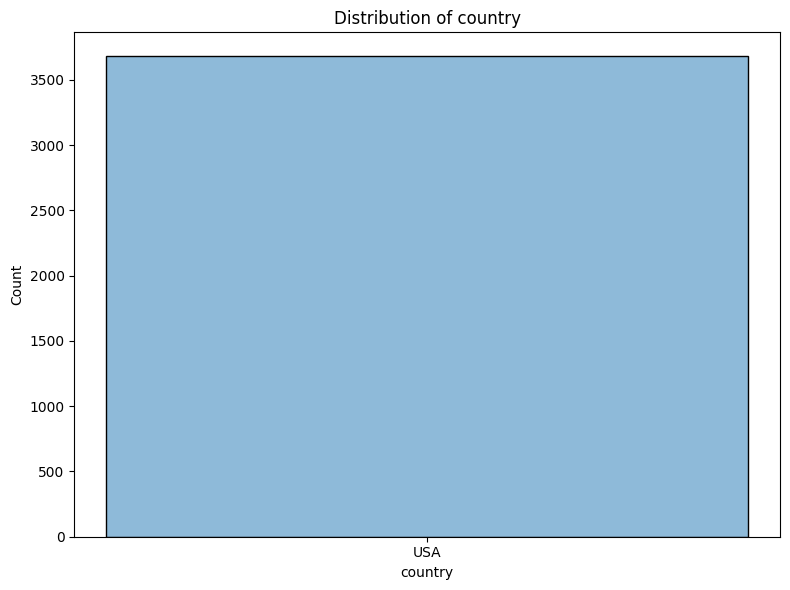

In [ ]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# Connect to the SQLite database
conn = sqlite3.connect('housing_data.db')

# Fetch data from the database into a Pandas DataFrame using SQL JOIN
query = '''
        SELECT h.date,h.price, h.bedrooms, h.bathrooms, h.sqft_living, h.sqft_lot, h.floors,
        h.waterfront, h.view, h.condition, h.sqft_above, h.sqft_basement, h.yr_built,
        h.yr_renovated, h.street, c.name AS city, s.code AS statezip, co.name AS country
        FROM  housing h
        JOIN city c ON h.city_id = c.id
        JOIN statezip s ON h.statezip_id = s.id;
'''
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Split the concatenated date strings into separate rows
df['date'] = df['date'].str.split('(?<=\d{2}:\d{2}:\d{2})', expand=True).stack().reset_index(level=1, drop=True).reset_index(drop=True)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Perform train/test split with stratification
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=pd.qcut(df['price'], q=10))

# Generate data profiling report for the train data
profile = ProfileReport(train_data, title="Housing Data Profiling Report")
profile.to_file("housing_data_profile.html")

# Categorize data into categorical and numerical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Identify null and missing values
null_values = train_data.isnull().sum()
missing_values = train_data.isna().sum()

print("Null Values:")
print(null_values)
print("\nMissing Values:")
print(missing_values)

# Plots
# Feature correlation heatmap with correlation values
plt.figure(figsize=(12, 10))
sns.heatmap(train_data[numerical_columns].corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Violin plots for correlation between target value and numeric features
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=column, y='price', data=test_data)
    plt.title(f'Violin Plot: {column} vs Price')
    plt.tight_layout()
    plt.show()

# Distribution of each attribute/feature
for column in train_data.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

# Develop a class-based preprocessor
class DataPreprocessor:
    def __init__(self, data):
        self.data = data

    def handle_missing_values(self, strategy='mean'):
        # Implement the strategy for handling missing values
        if strategy == 'mean':
            # Identify numeric columns
            numeric_cols = self.data.select_dtypes(include=['float64', 'int64']).columns

            # Replace missing values with mean for numeric columns
            for col in numeric_cols:
                self.data[col].fillna(self.data[col].mean(), inplace=True)

            # Replace missing values with 'missing' for non-numeric columns
            non_numeric_cols = self.data.columns.difference(numeric_cols)
            self.data[non_numeric_cols] = self.data[non_numeric_cols].fillna('missing')

        elif strategy == 'median':
            self.data.fillna(self.data.median(), inplace=True)
        elif strategy == 'mode':
            self.data.fillna(self.data.mode().iloc[0], inplace=True)
        else:
          raise ValueError("Invalid strategy for handling missing values.")

    def handle_non_normal_distribution(self):
        # Implement the strategy for handling non-normal distributions
        # Example: Log transformation for skewed features
        skewed_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
        for feature in skewed_features:+

            self.data[feature] = np.log1p(self.data[feature])

    def one_hot_encoding(self):
        # Implement one-hot encoding for categorical features
        self.data = pd.get_dummies(self.data)

    def scale_data(self, scaler=None):
        # Scale the data using the specified scaler
        if scaler is None:
            scaler = StandardScaler()
        self.data = scaler.fit_transform(self.data)

# Create an instance of the DataPreprocessor
preprocessor = DataPreprocessor(train_data)

# Handle missing values
preprocessor.handle_missing_values(strategy='mean')

# Handle non-normal distributions
preprocessor.handle_non_normal_distribution()

# Perform one-hot encoding
preprocessor.one_hot_encoding()

# Scale the data
preprocessor.scale_data()

# Get the preprocessed data
preprocessed_data = preprocessor.data
